<a href="https://colab.research.google.com/github/Honghai2102/vanishing_gradient_project/blob/Gradient_Vanishing_MLP/Gradient_Vanishing_MLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Libraries

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST
from torchsummary import summary

In [ ]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
cuda_device_count = torch.cuda.device_count()

print(f"CUDA Available: {cuda_available}")
print(f"Number of CUDA Devices: {cuda_device_count}")

if cuda_available:
    for i in range(cuda_device_count):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

CUDA Available: False
Number of CUDA Devices: 0


# II. Prepare Dataset

## *2.1. Set fit random*

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
set_seed(seed)

## *2.2. Split dataset*

In [ ]:
batch_size = 512
train_ratio = 0.9

dataset = FashionMNIST('./data',
                        train=True,
                        download=True,
                        transform=transforms.ToTensor())

test_dataset = FashionMNIST('./data',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())

train_size = int(len(dataset) * train_ratio)
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset,
                                        [train_size, val_size])

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=False)

print(f'Train size: {len(train_dataset)}')
print(f'Validation size: {len(val_dataset)}')
print(f'Test size: {len(test_dataset)}')

Train size: 54000
Validation size: 6000
Test size: 10000


## *2.3. MLP Model with vanishing gradient*

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dims, hidden_dims), nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims), nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims), nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims), nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims), nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims), nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims), nn.Sigmoid(),
            nn.Linear(hidden_dims, output_dims)
        )


    def forward(self, x):
        return self.model(x)

In [ ]:
input_dims = 784
hidden_dims = 128
output_dims = 10
learning_rate = 1e-2

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

summary(model, input_size=(1, 28, 28))  # Input size for FashionMNIST images

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
           Sigmoid-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
           Sigmoid-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
           Sigmoid-7                  [-1, 128]               0
            Linear-8                  [-1, 128]          16,512
           Sigmoid-9                  [-1, 128]               0
           Linear-10                  [-1, 128]          16,512
          Sigmoid-11                  [-1, 128]               0
           Linear-12                  [-1, 128]          16,512
          Sigmoid-13                  [-1, 128]               0
           Linear-14                  [

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

model.train()
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(input=outputs, dim=1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= count
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= count
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

Epoch 1/100, Train Loss: 2.3071, Train Acc: 0.1007, Validation Loss: 2.3028, Validation Acc: 0.0895
Epoch 2/100, Train Loss: 2.3028, Train Acc: 0.0995, Validation Loss: 2.3032, Validation Acc: 0.0997
Epoch 3/100, Train Loss: 2.3028, Train Acc: 0.0985, Validation Loss: 2.3028, Validation Acc: 0.1000
Epoch 4/100, Train Loss: 2.3027, Train Acc: 0.1001, Validation Loss: 2.3030, Validation Acc: 0.1020
Epoch 5/100, Train Loss: 2.3028, Train Acc: 0.0979, Validation Loss: 2.3030, Validation Acc: 0.0895
Epoch 6/100, Train Loss: 2.3028, Train Acc: 0.0989, Validation Loss: 2.3028, Validation Acc: 0.1000
Epoch 7/100, Train Loss: 2.3028, Train Acc: 0.1003, Validation Loss: 2.3033, Validation Acc: 0.1000
Epoch 8/100, Train Loss: 2.3028, Train Acc: 0.0991, Validation Loss: 2.3031, Validation Acc: 0.0895
Epoch 9/100, Train Loss: 2.3027, Train Acc: 0.1022, Validation Loss: 2.3026, Validation Acc: 0.1012
Epoch 10/100, Train Loss: 2.3028, Train Acc: 0.0990, Validation Loss: 2.3030, Validation Acc: 0.0895

In [ ]:
print(f"Weights of output layer: {model.model[15].weight.data.shape}")
print(f"Weights gradients of output layer: {model.model[15].weight.grad.shape}")
print(f"Bias of output layer: {model.model[15].bias.data.shape}")
print(f"Bias gradients of output layer: {model.model[15].bias.grad}")

Weights of output layer: torch.Size([10, 128])
Weights gradients of output layer: torch.Size([10, 128])
Bias of output layer: torch.Size([10])
Bias gradients of output layer: tensor([ 0.0031, -0.0090, -0.0134, -0.0076, -0.0120,  0.0587, -0.0017, -0.0287,
         0.0118, -0.0014])


In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Validation Loss
ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Training Accuracy
ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Validation Accuracy
ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_target = []
test_predict = []

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        outputs = model(x_test)

        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

print('Evaluation on test set:')
print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.1


## *2.4. Normal Distribution for init weight and bias*

### *2.4.1. Std is 1.0*

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dims, hidden_dims), nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims), nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims), nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims), nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims), nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims), nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims), nn.Sigmoid(),
            nn.Linear(hidden_dims, output_dims)
        )
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.0, std=1.0)
                nn.init.constant_(layer.bias, val=0.0)


    def forward(self, x):
        return self.model(x)

In [ ]:
input_dims = 784
hidden_dims = 128
output_dims = 10
learning_rate = 1e-2

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

summary(model, input_size=(1, 28, 28))  # Input size for FashionMNIST images

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
           Sigmoid-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
           Sigmoid-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
           Sigmoid-7                  [-1, 128]               0
            Linear-8                  [-1, 128]          16,512
           Sigmoid-9                  [-1, 128]               0
           Linear-10                  [-1, 128]          16,512
          Sigmoid-11                  [-1, 128]               0
           Linear-12                  [-1, 128]          16,512
          Sigmoid-13                  [-1, 128]               0
           Linear-14                  [

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

model.train()
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(input=outputs, dim=1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= count
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= count
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

Epoch 1/100, Train Loss: 3.3248, Train Acc: 0.1412, Validation Loss: 2.4011, Validation Acc: 0.1835
Epoch 2/100, Train Loss: 2.1854, Train Acc: 0.2375, Validation Loss: 2.0547, Validation Acc: 0.2680
Epoch 3/100, Train Loss: 1.9255, Train Acc: 0.3090, Validation Loss: 1.8519, Validation Acc: 0.3300
Epoch 4/100, Train Loss: 1.7483, Train Acc: 0.3644, Validation Loss: 1.7033, Validation Acc: 0.3762
Epoch 5/100, Train Loss: 1.6137, Train Acc: 0.4107, Validation Loss: 1.5858, Validation Acc: 0.4210
Epoch 6/100, Train Loss: 1.5085, Train Acc: 0.4465, Validation Loss: 1.4926, Validation Acc: 0.4505
Epoch 7/100, Train Loss: 1.4257, Train Acc: 0.4744, Validation Loss: 1.4158, Validation Acc: 0.4748
Epoch 8/100, Train Loss: 1.3594, Train Acc: 0.4976, Validation Loss: 1.3561, Validation Acc: 0.4982
Epoch 9/100, Train Loss: 1.3065, Train Acc: 0.5161, Validation Loss: 1.3053, Validation Acc: 0.5168
Epoch 10/100, Train Loss: 1.2622, Train Acc: 0.5317, Validation Loss: 1.2643, Validation Acc: 0.5328

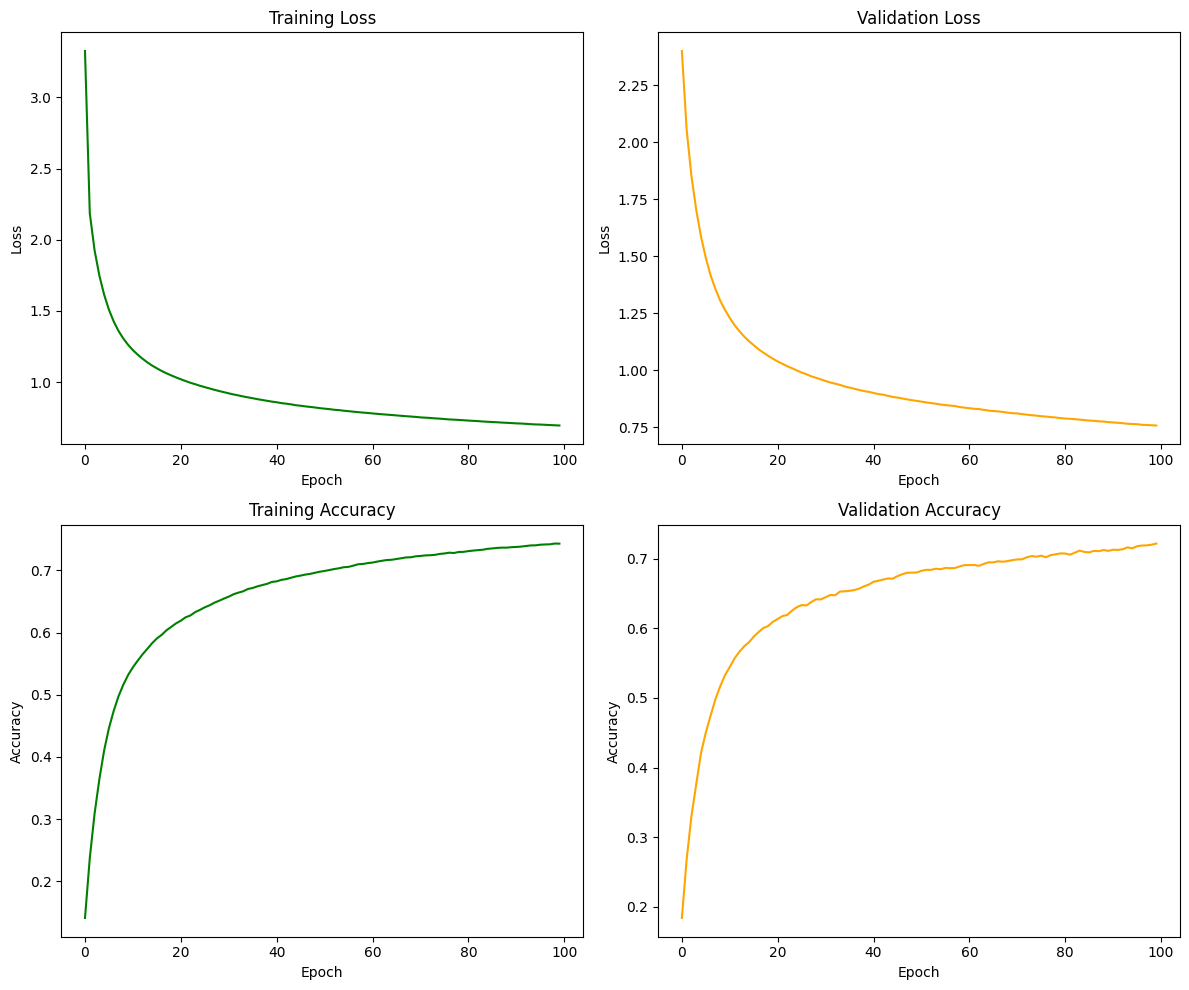

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Validation Loss
ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Training Accuracy
ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Validation Accuracy
ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_target = []
test_predict = []

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        outputs = model(x_test)

        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

print('Evaluation on test set:')
print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.722


### *2.4.2. Std is 10.0*

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dims, hidden_dims), nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims), nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims), nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims), nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims), nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims), nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims), nn.Sigmoid(),
            nn.Linear(hidden_dims, output_dims)
        )
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.0, std=10.0)
                nn.init.constant_(layer.bias, val=0.0)


    def forward(self, x):
        return self.model(x)

In [ ]:
input_dims = 784
hidden_dims = 128
output_dims = 10
learning_rate = 1e-2

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

summary(model, input_size=(1, 28, 28))  # Input size for FashionMNIST images

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
           Sigmoid-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
           Sigmoid-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
           Sigmoid-7                  [-1, 128]               0
            Linear-8                  [-1, 128]          16,512
           Sigmoid-9                  [-1, 128]               0
           Linear-10                  [-1, 128]          16,512
          Sigmoid-11                  [-1, 128]               0
           Linear-12                  [-1, 128]          16,512
          Sigmoid-13                  [-1, 128]               0
           Linear-14                  [

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

model.train()
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(input=outputs, dim=1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= count
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= count
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

Epoch 1/100, Train Loss: 125.3106, Train Acc: 0.1039, Validation Loss: 92.8400, Validation Acc: 0.1008
Epoch 2/100, Train Loss: 85.4749, Train Acc: 0.1029, Validation Loss: 79.3518, Validation Acc: 0.0990
Epoch 3/100, Train Loss: 72.1607, Train Acc: 0.1003, Validation Loss: 61.3144, Validation Acc: 0.1433
Epoch 4/100, Train Loss: 59.5519, Train Acc: 0.1042, Validation Loss: 58.8070, Validation Acc: 0.0963
Epoch 5/100, Train Loss: 47.8792, Train Acc: 0.1101, Validation Loss: 47.3159, Validation Acc: 0.0757
Epoch 6/100, Train Loss: 22.6756, Train Acc: 0.0863, Validation Loss: 15.1588, Validation Acc: 0.1112
Epoch 7/100, Train Loss: 15.6573, Train Acc: 0.1119, Validation Loss: 13.1178, Validation Acc: 0.1307
Epoch 8/100, Train Loss: 11.6069, Train Acc: 0.1318, Validation Loss: 8.9371, Validation Acc: 0.1587
Epoch 9/100, Train Loss: 8.3230, Train Acc: 0.1465, Validation Loss: 7.8511, Validation Acc: 0.1193
Epoch 10/100, Train Loss: 6.6892, Train Acc: 0.1335, Validation Loss: 5.8317, Valida

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Validation Loss
ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Training Accuracy
ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Validation Accuracy
ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_target = []
test_predict = []

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        outputs = model(x_test)

        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

print('Evaluation on test set:')
print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.1144


## *2.5. ReLU function for activation*

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dims, hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, output_dims)
        )
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.0, std=0.05)
                nn.init.constant_(layer.bias, val=0.0)


    def forward(self, x):
        return self.model(x)

In [ ]:
input_dims = 784
hidden_dims = 128
output_dims = 10
learning_rate = 1e-2

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

summary(model, input_size=(1, 28, 28))  # Input size for FashionMNIST images

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
              ReLU-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
              ReLU-7                  [-1, 128]               0
            Linear-8                  [-1, 128]          16,512
              ReLU-9                  [-1, 128]               0
           Linear-10                  [-1, 128]          16,512
             ReLU-11                  [-1, 128]               0
           Linear-12                  [-1, 128]          16,512
             ReLU-13                  [-1, 128]               0
           Linear-14                  [

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

model.train()
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(input=outputs, dim=1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= count
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= count
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

Epoch 1/100, Train Loss: 2.3024, Train Acc: 0.1170, Validation Loss: 2.3024, Validation Acc: 0.1392
Epoch 2/100, Train Loss: 2.3023, Train Acc: 0.1335, Validation Loss: 2.3023, Validation Acc: 0.1455
Epoch 3/100, Train Loss: 2.3022, Train Acc: 0.1490, Validation Loss: 2.3022, Validation Acc: 0.1315
Epoch 4/100, Train Loss: 2.3020, Train Acc: 0.1333, Validation Loss: 2.3021, Validation Acc: 0.1165
Epoch 5/100, Train Loss: 2.3019, Train Acc: 0.1326, Validation Loss: 2.3020, Validation Acc: 0.1087
Epoch 6/100, Train Loss: 2.3018, Train Acc: 0.1445, Validation Loss: 2.3019, Validation Acc: 0.1048
Epoch 7/100, Train Loss: 2.3016, Train Acc: 0.1357, Validation Loss: 2.3017, Validation Acc: 0.1063
Epoch 8/100, Train Loss: 2.3015, Train Acc: 0.1272, Validation Loss: 2.3016, Validation Acc: 0.1057
Epoch 9/100, Train Loss: 2.3013, Train Acc: 0.1254, Validation Loss: 2.3014, Validation Acc: 0.1078
Epoch 10/100, Train Loss: 2.3012, Train Acc: 0.1243, Validation Loss: 2.3013, Validation Acc: 0.1125

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Validation Loss
ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Training Accuracy
ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Validation Accuracy
ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_target = []
test_predict = []

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        outputs = model(x_test)

        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

print('Evaluation on test set:')
print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.8135


## *2.6. Adam optimizer for calcutation gradients*

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dims, hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, output_dims)
        )
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.0, std=0.05)
                nn.init.constant_(layer.bias, val=0.0)


    def forward(self, x):
        return self.model(x)

In [ ]:
input_dims = 784
hidden_dims = 128
output_dims = 10
learning_rate = 1e-3

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

summary(model, input_size=(1, 28, 28))  # Input size for FashionMNIST images

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
              ReLU-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
              ReLU-7                  [-1, 128]               0
            Linear-8                  [-1, 128]          16,512
              ReLU-9                  [-1, 128]               0
           Linear-10                  [-1, 128]          16,512
             ReLU-11                  [-1, 128]               0
           Linear-12                  [-1, 128]          16,512
             ReLU-13                  [-1, 128]               0
           Linear-14                  [

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

model.train()
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(input=outputs, dim=1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= count
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= count
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

Epoch 1/100, Train Loss: 1.1350, Train Acc: 0.5617, Validation Loss: 0.7458, Validation Acc: 0.7155
Epoch 2/100, Train Loss: 0.6498, Train Acc: 0.7605, Validation Loss: 0.5672, Validation Acc: 0.7943
Epoch 3/100, Train Loss: 0.5124, Train Acc: 0.8151, Validation Loss: 0.4946, Validation Acc: 0.8265
Epoch 4/100, Train Loss: 0.4598, Train Acc: 0.8381, Validation Loss: 0.4508, Validation Acc: 0.8438
Epoch 5/100, Train Loss: 0.4191, Train Acc: 0.8521, Validation Loss: 0.4362, Validation Acc: 0.8433
Epoch 6/100, Train Loss: 0.3812, Train Acc: 0.8637, Validation Loss: 0.4180, Validation Acc: 0.8558
Epoch 7/100, Train Loss: 0.3678, Train Acc: 0.8687, Validation Loss: 0.4100, Validation Acc: 0.8525
Epoch 8/100, Train Loss: 0.3524, Train Acc: 0.8729, Validation Loss: 0.4094, Validation Acc: 0.8617
Epoch 9/100, Train Loss: 0.3294, Train Acc: 0.8811, Validation Loss: 0.3907, Validation Acc: 0.8685
Epoch 10/100, Train Loss: 0.3177, Train Acc: 0.8856, Validation Loss: 0.3607, Validation Acc: 0.8698

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Validation Loss
ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Training Accuracy
ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Validation Accuracy
ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_target = []
test_predict = []

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        outputs = model(x_test)

        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

print('Evaluation on test set:')
print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.88


## *2.7. Batch Normalization for normalize inside network*

### *2.7.1. BatchNorm1d*

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, output_dims)
        )
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.0, std=0.05)
                nn.init.constant_(layer.bias, val=0.0)


    def forward(self, x):
        return self.model(x)

In [ ]:
input_dims = 784
hidden_dims = 128
output_dims = 10
learning_rate = 1e-3

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

summary(model, input_size=(1, 28, 28))  # Input size for FashionMNIST images

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
       BatchNorm1d-3                  [-1, 128]             256
              ReLU-4                  [-1, 128]               0
            Linear-5                  [-1, 128]          16,512
       BatchNorm1d-6                  [-1, 128]             256
              ReLU-7                  [-1, 128]               0
            Linear-8                  [-1, 128]          16,512
       BatchNorm1d-9                  [-1, 128]             256
             ReLU-10                  [-1, 128]               0
           Linear-11                  [-1, 128]          16,512
      BatchNorm1d-12                  [-1, 128]             256
             ReLU-13                  [-1, 128]               0
           Linear-14                  [

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

model.train()
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(input=outputs, dim=1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= count
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= count
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

Epoch 1/100, Train Loss: 0.5964, Train Acc: 0.8099, Validation Loss: 0.4137, Validation Acc: 0.8585
Epoch 2/100, Train Loss: 0.3808, Train Acc: 0.8618, Validation Loss: 0.3743, Validation Acc: 0.8618
Epoch 3/100, Train Loss: 0.3220, Train Acc: 0.8809, Validation Loss: 0.3624, Validation Acc: 0.8753
Epoch 4/100, Train Loss: 0.3028, Train Acc: 0.8881, Validation Loss: 0.3531, Validation Acc: 0.8688
Epoch 5/100, Train Loss: 0.2870, Train Acc: 0.8929, Validation Loss: 0.3405, Validation Acc: 0.8793
Epoch 6/100, Train Loss: 0.2741, Train Acc: 0.8975, Validation Loss: 0.3477, Validation Acc: 0.8757
Epoch 7/100, Train Loss: 0.2584, Train Acc: 0.9019, Validation Loss: 0.3255, Validation Acc: 0.8808
Epoch 8/100, Train Loss: 0.2494, Train Acc: 0.9061, Validation Loss: 0.3348, Validation Acc: 0.8815
Epoch 9/100, Train Loss: 0.2372, Train Acc: 0.9108, Validation Loss: 0.3267, Validation Acc: 0.8862
Epoch 10/100, Train Loss: 0.2305, Train Acc: 0.9127, Validation Loss: 0.3376, Validation Acc: 0.8832

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Validation Loss
ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Training Accuracy
ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Validation Accuracy
ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_target = []
test_predict = []

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        outputs = model(x_test)

        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

print('Evaluation on test set:')
print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.8858


### *2.7.2. MyNormalization*

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dims, hidden_dims),
            MyNormalization(hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            MyNormalization(hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            MyNormalization(hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            MyNormalization(hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            MyNormalization(hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            MyNormalization(hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            MyNormalization(hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, output_dims)
        )
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.0, std=0.05)
                nn.init.constant_(layer.bias, val=0.0)


    def forward(self, x):
        return self.model(x)


class MyNormalization(nn.Module):
    def __init__(self):
        super(MyNormalization, self).__init__()


    def forward(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean) / std

In [ ]:
input_dims = 784
hidden_dims = 128
output_dims = 10
learning_rate = 1e-3

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

summary(model, input_size=(1, 28, 28))  # Input size for FashionMNIST images

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
           Sigmoid-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
           Sigmoid-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
           Sigmoid-7                  [-1, 128]               0
            Linear-8                  [-1, 128]          16,512
           Sigmoid-9                  [-1, 128]               0
           Linear-10                  [-1, 128]          16,512
          Sigmoid-11                  [-1, 128]               0
           Linear-12                  [-1, 128]          16,512
          Sigmoid-13                  [-1, 128]               0
           Linear-14                  [

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

model.train()
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(input=outputs, dim=1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= count
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= count
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

Epoch 1/100, Train Loss: 3.3248, Train Acc: 0.1412, Validation Loss: 2.4011, Validation Acc: 0.1835
Epoch 2/100, Train Loss: 2.1854, Train Acc: 0.2375, Validation Loss: 2.0547, Validation Acc: 0.2680
Epoch 3/100, Train Loss: 1.9255, Train Acc: 0.3090, Validation Loss: 1.8519, Validation Acc: 0.3300
Epoch 4/100, Train Loss: 1.7483, Train Acc: 0.3644, Validation Loss: 1.7033, Validation Acc: 0.3762
Epoch 5/100, Train Loss: 1.6137, Train Acc: 0.4107, Validation Loss: 1.5858, Validation Acc: 0.4210
Epoch 6/100, Train Loss: 1.5085, Train Acc: 0.4465, Validation Loss: 1.4926, Validation Acc: 0.4505
Epoch 7/100, Train Loss: 1.4257, Train Acc: 0.4744, Validation Loss: 1.4158, Validation Acc: 0.4748
Epoch 8/100, Train Loss: 1.3594, Train Acc: 0.4976, Validation Loss: 1.3561, Validation Acc: 0.4982
Epoch 9/100, Train Loss: 1.3065, Train Acc: 0.5161, Validation Loss: 1.3053, Validation Acc: 0.5168
Epoch 10/100, Train Loss: 1.2622, Train Acc: 0.5317, Validation Loss: 1.2643, Validation Acc: 0.5328

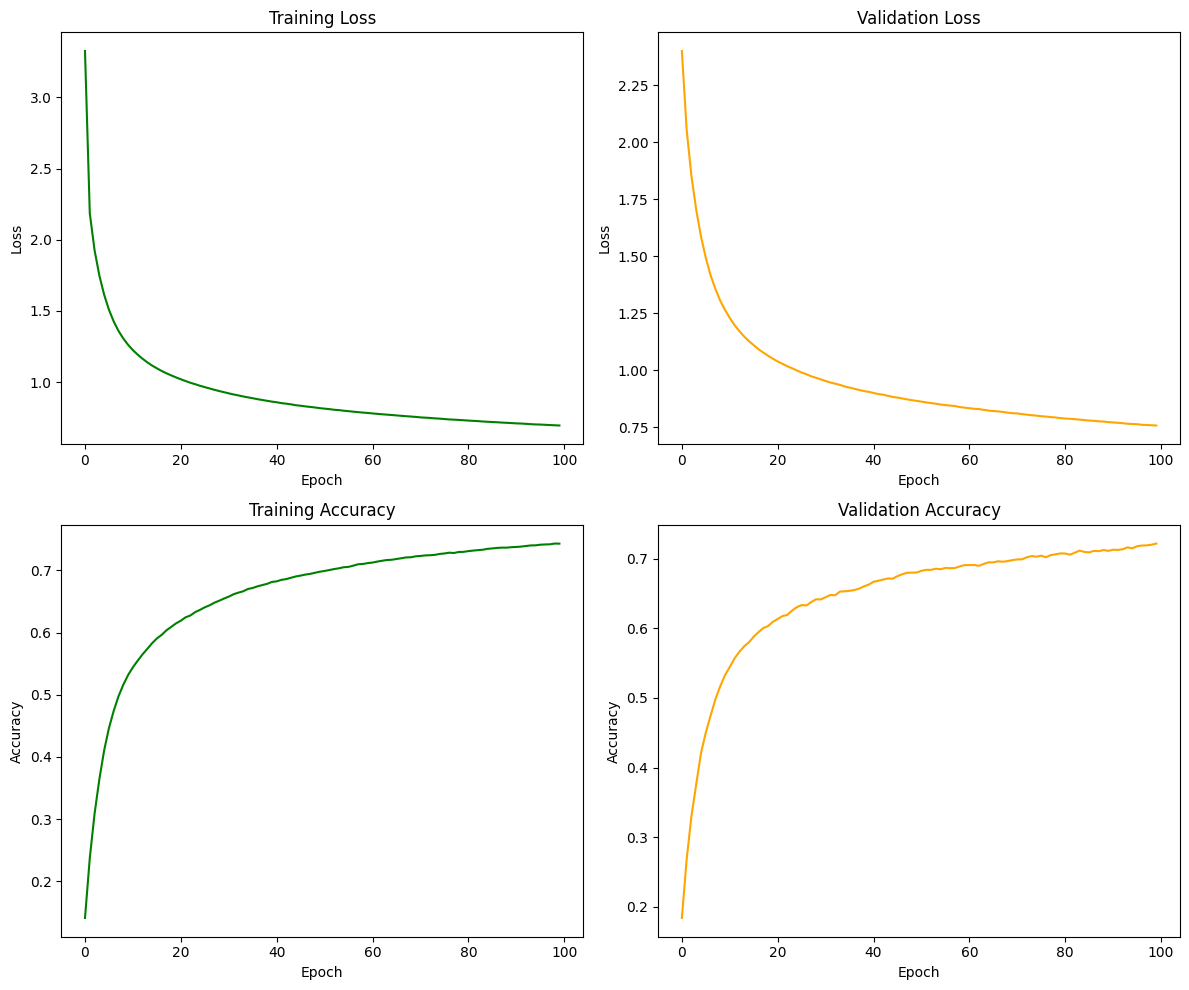

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Validation Loss
ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Training Accuracy
ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Validation Accuracy
ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_target = []
test_predict = []

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        outputs = model(x_test)

        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

print('Evaluation on test set:')
print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.722


## *2.8. Skip Connection*

![image.png](attachment:image.png)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
        )
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
        )
        self.hidden_layer2 = nn.Sequential(
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
        )
        self.hidden_layer3 = nn.Sequential(
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
        )
        self.output_layer = nn.Sequential(
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, output_dims)
        )
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.0, std=0.05)
                nn.init.constant_(layer.bias, val=0.0)


    def forward(self, x):
        x = self.input_layer(x)
        skip = x;
        x = self.hidden_layer1(x)
        x = skip + x
        x = self.hidden_layer2(x)
        skip = x;
        x = self.hidden_layer3(x)
        x = skip + x
        return self.output_layer(x)

In [ ]:
input_dims = 784
hidden_dims = 128
output_dims = 10
learning_rate = 1e-3

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

summary(model, input_size=(1, 28, 28))  # Input size for FashionMNIST images

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
       BatchNorm1d-3                  [-1, 128]             256
              ReLU-4                  [-1, 128]               0
            Linear-5                  [-1, 128]          16,512
       BatchNorm1d-6                  [-1, 128]             256
              ReLU-7                  [-1, 128]               0
            Linear-8                  [-1, 128]          16,512
       BatchNorm1d-9                  [-1, 128]             256
             ReLU-10                  [-1, 128]               0
           Linear-11                  [-1, 128]          16,512
      BatchNorm1d-12                  [-1, 128]             256
             ReLU-13                  [-1, 128]               0
           Linear-14                  [

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

model.train()
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(input=outputs, dim=1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= count
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= count
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

Epoch 1/100, Train Loss: 0.5956, Train Acc: 0.8108, Validation Loss: 0.4071, Validation Acc: 0.8533
Epoch 2/100, Train Loss: 0.3636, Train Acc: 0.8676, Validation Loss: 0.3689, Validation Acc: 0.8663
Epoch 3/100, Train Loss: 0.3198, Train Acc: 0.8806, Validation Loss: 0.3578, Validation Acc: 0.8728
Epoch 4/100, Train Loss: 0.2966, Train Acc: 0.8901, Validation Loss: 0.3411, Validation Acc: 0.8788
Epoch 5/100, Train Loss: 0.2778, Train Acc: 0.8956, Validation Loss: 0.3316, Validation Acc: 0.8773
Epoch 6/100, Train Loss: 0.2650, Train Acc: 0.9009, Validation Loss: 0.3428, Validation Acc: 0.8787
Epoch 7/100, Train Loss: 0.2536, Train Acc: 0.9050, Validation Loss: 0.3390, Validation Acc: 0.8763
Epoch 8/100, Train Loss: 0.2447, Train Acc: 0.9080, Validation Loss: 0.3386, Validation Acc: 0.8802
Epoch 9/100, Train Loss: 0.2334, Train Acc: 0.9125, Validation Loss: 0.3265, Validation Acc: 0.8840
Epoch 10/100, Train Loss: 0.2194, Train Acc: 0.9161, Validation Loss: 0.3312, Validation Acc: 0.8830

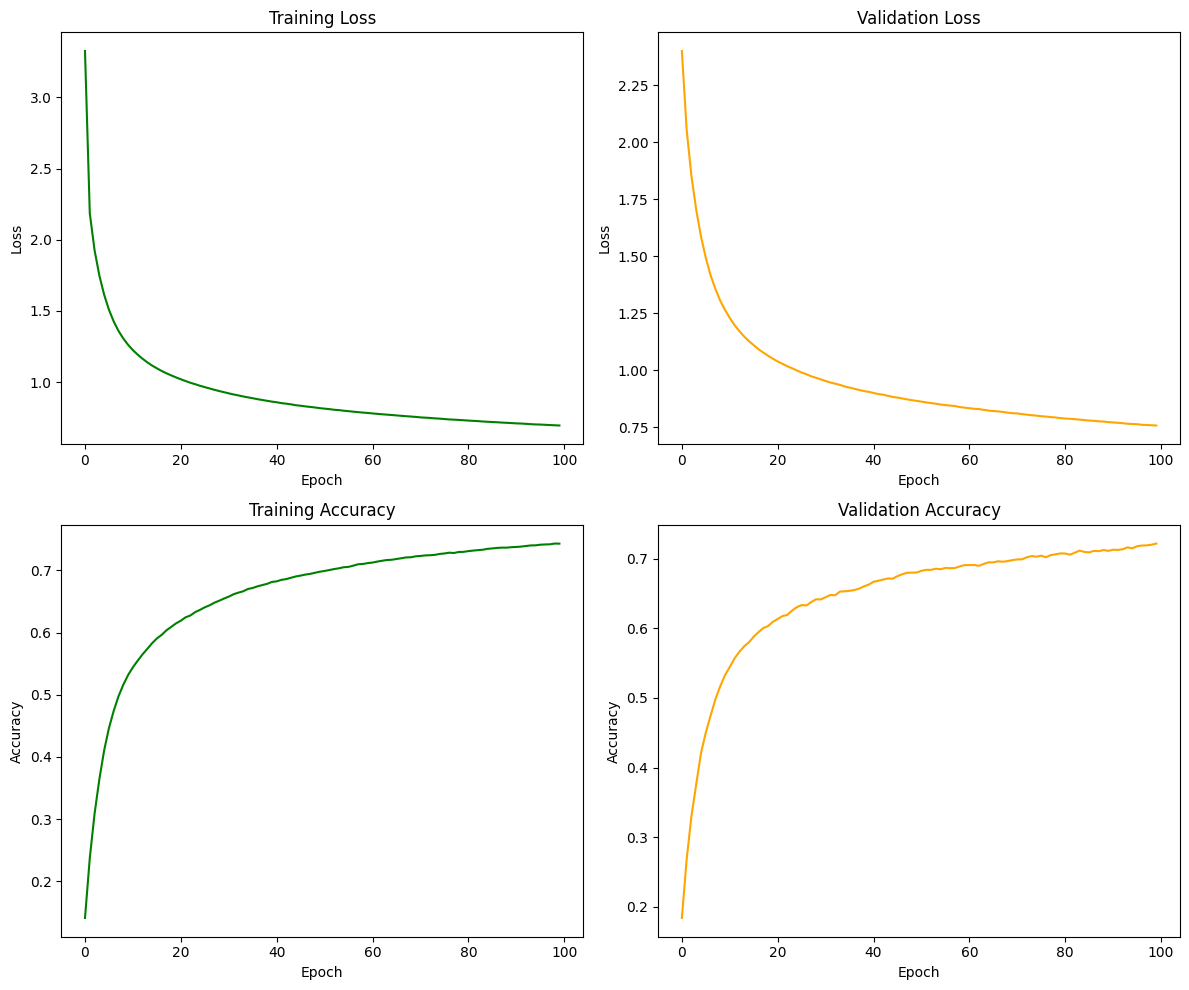

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Validation Loss
ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Training Accuracy
ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Validation Accuracy
ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_target = []
test_predict = []

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        outputs = model(x_test)

        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

print('Evaluation on test set:')
print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.8864


## *2.9. Train layers separately*

![image.png](attachment:image.png)

In [ ]:
class MLP_Input(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_Input, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dims, output_dims),
            nn.BatchNorm1d(output_dims), nn.ReLU(),
        )
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.0, std=0.05)
                nn.init.constant_(layer.bias, val=0.0)


    def forward(self, x):
        return self.model(x)


class MLP_Hidden(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP_Hidden, self).__init__()
        self.hidden_dims = hidden_dims
        self.output_dims = output_dims
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, output_dims)

        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.0, std=0.05)
                nn.init.constant_(layer.bias, val=0.0)


    def forward(self, x):
        x = self.layer1(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.BatchNorm1d(self.output_dims)(x)
        x = nn.ReLU()(x)
        return x

In [ ]:
input_dims = 784
hidden_dims = 128
output_dims = 10
learning_rate = 1e-3

first = MLP_Input(input_dims=input_dims,
                  output_dims=hidden_dims).to(device)
second = MLP_Hidden(input_dims=hidden_dims,
                    hidden_dims=hidden_dims,
                    output_dims=hidden_dims).to(device)
third = MLP_Hidden(input_dims=hidden_dims,
                    hidden_dims=hidden_dims,
                    output_dims=hidden_dims).to(device)
fourth = MLP_Hidden(input_dims=hidden_dims,
                    hidden_dims=hidden_dims,
                    output_dims=hidden_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
model = nn.Sequential(first,
                      nn.Linear(hidden_dims, output_dims)
                      ).to(device)
summary(model, input_size=(1, 28, 28))  # Input size for FashionMNIST images

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
       BatchNorm1d-3                  [-1, 128]             256
              ReLU-4                  [-1, 128]               0
         MLP_Input-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 102,026
Trainable params: 102,026
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


In [ ]:
epochs = 15
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

model.train()
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(input=outputs, dim=1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= count
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= count
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

Epoch 1/15, Train Loss: 2.3948, Train Acc: 0.1319, Validation Loss: 2.3971, Validation Acc: 0.1280
Epoch 2/15, Train Loss: 2.3946, Train Acc: 0.1340, Validation Loss: 2.3971, Validation Acc: 0.1280
Epoch 3/15, Train Loss: 2.3948, Train Acc: 0.1340, Validation Loss: 2.3971, Validation Acc: 0.1280
Epoch 4/15, Train Loss: 2.3945, Train Acc: 0.1340, Validation Loss: 2.3971, Validation Acc: 0.1280
Epoch 5/15, Train Loss: 2.3947, Train Acc: 0.1340, Validation Loss: 2.3971, Validation Acc: 0.1280
Epoch 6/15, Train Loss: 2.3945, Train Acc: 0.1340, Validation Loss: 2.3971, Validation Acc: 0.1280
Epoch 7/15, Train Loss: 2.3946, Train Acc: 0.1340, Validation Loss: 2.3971, Validation Acc: 0.1280
Epoch 8/15, Train Loss: 2.3945, Train Acc: 0.1340, Validation Loss: 2.3971, Validation Acc: 0.1280
Epoch 9/15, Train Loss: 2.3945, Train Acc: 0.1340, Validation Loss: 2.3971, Validation Acc: 0.1280
Epoch 10/15, Train Loss: 2.3945, Train Acc: 0.1340, Validation Loss: 2.3971, Validation Acc: 0.1280
Epoch 11/

In [ ]:
for param in first.parameters():
    param.requires_grad = False

model = nn.Sequential(first,
                      second,
                      nn.Linear(hidden_dims, output_dims)
                      ).to(device)
summary(model, input_size=(1, 28, 28))  # Input size for FashionMNIST images

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
       BatchNorm1d-3                  [-1, 128]             256
              ReLU-4                  [-1, 128]               0
         MLP_Input-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
            Linear-7                  [-1, 128]          16,512
        MLP_Hidden-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 135,050
Trainable params: 34,314
Non-trainable params: 100,736
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.52
Estimated Total Size (MB): 0.53
--------------------------------------

In [ ]:
model.train()
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(input=outputs, dim=1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= count
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= count
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

Epoch 1/15, Train Loss: 2.3878, Train Acc: 0.0985, Validation Loss: 2.3843, Validation Acc: 0.1048
Epoch 2/15, Train Loss: 2.3883, Train Acc: 0.0985, Validation Loss: 2.3843, Validation Acc: 0.1048
Epoch 3/15, Train Loss: 2.3884, Train Acc: 0.0982, Validation Loss: 2.3843, Validation Acc: 0.1048
Epoch 4/15, Train Loss: 2.3883, Train Acc: 0.0987, Validation Loss: 2.3843, Validation Acc: 0.1048
Epoch 5/15, Train Loss: 2.3884, Train Acc: 0.0995, Validation Loss: 2.3843, Validation Acc: 0.1048
Epoch 6/15, Train Loss: 2.3880, Train Acc: 0.0987, Validation Loss: 2.3843, Validation Acc: 0.1048
Epoch 7/15, Train Loss: 2.3882, Train Acc: 0.0991, Validation Loss: 2.3843, Validation Acc: 0.1048
Epoch 8/15, Train Loss: 2.3883, Train Acc: 0.0989, Validation Loss: 2.3843, Validation Acc: 0.1048
Epoch 9/15, Train Loss: 2.3884, Train Acc: 0.0983, Validation Loss: 2.3843, Validation Acc: 0.1048
Epoch 10/15, Train Loss: 2.3880, Train Acc: 0.0981, Validation Loss: 2.3843, Validation Acc: 0.1048
Epoch 11/

In [ ]:
for param in first.parameters():
    param.requires_grad = True

model = nn.Sequential(first,
                      second,
                      nn.Linear(hidden_dims, output_dims)
                      ).to(device)
summary(model, input_size=(1, 28, 28))  # Input size for FashionMNIST images

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
       BatchNorm1d-3                  [-1, 128]             256
              ReLU-4                  [-1, 128]               0
         MLP_Input-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
            Linear-7                  [-1, 128]          16,512
        MLP_Hidden-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 135,050
Trainable params: 135,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.52
Estimated Total Size (MB): 0.53
-------------------------------------------

In [ ]:
model.train()
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(input=outputs, dim=1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= count
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= count
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

Epoch 1/15, Train Loss: 2.4303, Train Acc: 0.0859, Validation Loss: 2.4460, Validation Acc: 0.0762
Epoch 2/15, Train Loss: 2.4310, Train Acc: 0.0857, Validation Loss: 2.4460, Validation Acc: 0.0762
Epoch 3/15, Train Loss: 2.4307, Train Acc: 0.0865, Validation Loss: 2.4460, Validation Acc: 0.0762
Epoch 4/15, Train Loss: 2.4309, Train Acc: 0.0863, Validation Loss: 2.4460, Validation Acc: 0.0762
Epoch 5/15, Train Loss: 2.4306, Train Acc: 0.0861, Validation Loss: 2.4460, Validation Acc: 0.0762
Epoch 6/15, Train Loss: 2.4308, Train Acc: 0.0858, Validation Loss: 2.4460, Validation Acc: 0.0762
Epoch 7/15, Train Loss: 2.4307, Train Acc: 0.0862, Validation Loss: 2.4460, Validation Acc: 0.0762
Epoch 8/15, Train Loss: 2.4308, Train Acc: 0.0864, Validation Loss: 2.4460, Validation Acc: 0.0762
Epoch 9/15, Train Loss: 2.4307, Train Acc: 0.0858, Validation Loss: 2.4460, Validation Acc: 0.0762
Epoch 10/15, Train Loss: 2.4309, Train Acc: 0.0861, Validation Loss: 2.4460, Validation Acc: 0.0762
Epoch 11/

In [ ]:
for param in first.parameters():
    param.requires_grad = False
for param in second.parameters():
    param.requires_grad = False

model = nn.Sequential(first,
                      second,
                      third,
                      nn.Linear(hidden_dims, output_dims)
                      ).to(device)
summary(model, input_size=(1, 28, 28))  # Input size for FashionMNIST images

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
       BatchNorm1d-3                  [-1, 128]             256
              ReLU-4                  [-1, 128]               0
         MLP_Input-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
            Linear-7                  [-1, 128]          16,512
        MLP_Hidden-8                  [-1, 128]               0
            Linear-9                  [-1, 128]          16,512
           Linear-10                  [-1, 128]          16,512
       MLP_Hidden-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 168,074
Trainable params: 34,314
Non-trainable params: 133,760
--------------------------

In [ ]:
model.train()
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(input=outputs, dim=1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= count
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= count
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

Epoch 1/15, Train Loss: 2.4944, Train Acc: 0.0793, Validation Loss: 2.4969, Validation Acc: 0.0765
Epoch 2/15, Train Loss: 2.4951, Train Acc: 0.0792, Validation Loss: 2.4969, Validation Acc: 0.0765
Epoch 3/15, Train Loss: 2.4948, Train Acc: 0.0783, Validation Loss: 2.4969, Validation Acc: 0.0765
Epoch 4/15, Train Loss: 2.4949, Train Acc: 0.0795, Validation Loss: 2.4969, Validation Acc: 0.0765
Epoch 5/15, Train Loss: 2.4951, Train Acc: 0.0782, Validation Loss: 2.4969, Validation Acc: 0.0765
Epoch 6/15, Train Loss: 2.4947, Train Acc: 0.0787, Validation Loss: 2.4969, Validation Acc: 0.0765
Epoch 7/15, Train Loss: 2.4947, Train Acc: 0.0787, Validation Loss: 2.4969, Validation Acc: 0.0765
Epoch 8/15, Train Loss: 2.4949, Train Acc: 0.0782, Validation Loss: 2.4969, Validation Acc: 0.0765
Epoch 9/15, Train Loss: 2.4943, Train Acc: 0.0794, Validation Loss: 2.4969, Validation Acc: 0.0765
Epoch 10/15, Train Loss: 2.4951, Train Acc: 0.0788, Validation Loss: 2.4969, Validation Acc: 0.0765
Epoch 11/

In [ ]:
for param in first.parameters():
    param.requires_grad = True
for param in second.parameters():
    param.requires_grad = True

model = nn.Sequential(first,
                      second,
                      third,
                      nn.Linear(hidden_dims, output_dims)
                      ).to(device)
summary(model, input_size=(1, 28, 28))  # Input size for FashionMNIST images

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
       BatchNorm1d-3                  [-1, 128]             256
              ReLU-4                  [-1, 128]               0
         MLP_Input-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
            Linear-7                  [-1, 128]          16,512
        MLP_Hidden-8                  [-1, 128]               0
            Linear-9                  [-1, 128]          16,512
           Linear-10                  [-1, 128]          16,512
       MLP_Hidden-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 168,074
Trainable params: 168,074
Non-trainable params: 0
-------------------------------

In [ ]:
model.train()
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(input=outputs, dim=1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= count
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= count
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

Epoch 1/15, Train Loss: 2.3822, Train Acc: 0.0746, Validation Loss: 2.3846, Validation Acc: 0.0680
Epoch 2/15, Train Loss: 2.3817, Train Acc: 0.0772, Validation Loss: 2.3846, Validation Acc: 0.0680
Epoch 3/15, Train Loss: 2.3811, Train Acc: 0.0762, Validation Loss: 2.3846, Validation Acc: 0.0680
Epoch 4/15, Train Loss: 2.3810, Train Acc: 0.0761, Validation Loss: 2.3846, Validation Acc: 0.0680
Epoch 5/15, Train Loss: 2.3810, Train Acc: 0.0756, Validation Loss: 2.3846, Validation Acc: 0.0680
Epoch 6/15, Train Loss: 2.3811, Train Acc: 0.0759, Validation Loss: 2.3846, Validation Acc: 0.0680
Epoch 7/15, Train Loss: 2.3808, Train Acc: 0.0766, Validation Loss: 2.3846, Validation Acc: 0.0680
Epoch 8/15, Train Loss: 2.3808, Train Acc: 0.0760, Validation Loss: 2.3846, Validation Acc: 0.0680
Epoch 9/15, Train Loss: 2.3810, Train Acc: 0.0749, Validation Loss: 2.3846, Validation Acc: 0.0680
Epoch 10/15, Train Loss: 2.3812, Train Acc: 0.0753, Validation Loss: 2.3846, Validation Acc: 0.0680
Epoch 11/

In [ ]:
for param in first.parameters():
    param.requires_grad = False
for param in second.parameters():
    param.requires_grad = False
for param in third.parameters():
    param.requires_grad = False

model = nn.Sequential(first,
                      second,
                      third,
                      fourth,
                      nn.Linear(hidden_dims, output_dims)
                      ).to(device)
summary(model, input_size=(1, 28, 28))  # Input size for FashionMNIST images

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
       BatchNorm1d-3                  [-1, 128]             256
              ReLU-4                  [-1, 128]               0
         MLP_Input-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
            Linear-7                  [-1, 128]          16,512
        MLP_Hidden-8                  [-1, 128]               0
            Linear-9                  [-1, 128]          16,512
           Linear-10                  [-1, 128]          16,512
       MLP_Hidden-11                  [-1, 128]               0
           Linear-12                  [-1, 128]          16,512
           Linear-13                  [-1, 128]          16,512
       MLP_Hidden-14                  [

In [ ]:
model.train()
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(input=outputs, dim=1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= count
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= count
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

Epoch 1/15, Train Loss: 2.3775, Train Acc: 0.1084, Validation Loss: 2.3655, Validation Acc: 0.1162
Epoch 2/15, Train Loss: 2.3782, Train Acc: 0.1093, Validation Loss: 2.3655, Validation Acc: 0.1162
Epoch 3/15, Train Loss: 2.3788, Train Acc: 0.1087, Validation Loss: 2.3655, Validation Acc: 0.1162
Epoch 4/15, Train Loss: 2.3776, Train Acc: 0.1091, Validation Loss: 2.3655, Validation Acc: 0.1162
Epoch 5/15, Train Loss: 2.3773, Train Acc: 0.1081, Validation Loss: 2.3655, Validation Acc: 0.1162
Epoch 6/15, Train Loss: 2.3774, Train Acc: 0.1090, Validation Loss: 2.3655, Validation Acc: 0.1162
Epoch 7/15, Train Loss: 2.3769, Train Acc: 0.1086, Validation Loss: 2.3655, Validation Acc: 0.1162
Epoch 8/15, Train Loss: 2.3780, Train Acc: 0.1085, Validation Loss: 2.3655, Validation Acc: 0.1162
Epoch 9/15, Train Loss: 2.3773, Train Acc: 0.1092, Validation Loss: 2.3655, Validation Acc: 0.1162
Epoch 10/15, Train Loss: 2.3780, Train Acc: 0.1092, Validation Loss: 2.3655, Validation Acc: 0.1162
Epoch 11/

In [ ]:
for param in first.parameters():
    param.requires_grad = True
for param in second.parameters():
    param.requires_grad = True
for param in third.parameters():
    param.requires_grad = True

model = nn.Sequential(first,
                      second,
                      third,
                      fourth,
                      nn.Linear(hidden_dims, output_dims)
                      ).to(device)
summary(model, input_size=(1, 28, 28))  # Input size for FashionMNIST images

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
       BatchNorm1d-3                  [-1, 128]             256
              ReLU-4                  [-1, 128]               0
         MLP_Input-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
            Linear-7                  [-1, 128]          16,512
        MLP_Hidden-8                  [-1, 128]               0
            Linear-9                  [-1, 128]          16,512
           Linear-10                  [-1, 128]          16,512
       MLP_Hidden-11                  [-1, 128]               0
           Linear-12                  [-1, 128]          16,512
           Linear-13                  [-1, 128]          16,512
       MLP_Hidden-14                  [

In [ ]:
model.train()
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(input=outputs, dim=1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= count
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= count
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

Epoch 1/15, Train Loss: 2.3675, Train Acc: 0.0928, Validation Loss: 2.3616, Validation Acc: 0.0968
Epoch 2/15, Train Loss: 2.3677, Train Acc: 0.0916, Validation Loss: 2.3616, Validation Acc: 0.0968
Epoch 3/15, Train Loss: 2.3681, Train Acc: 0.0914, Validation Loss: 2.3616, Validation Acc: 0.0968
Epoch 4/15, Train Loss: 2.3681, Train Acc: 0.0922, Validation Loss: 2.3616, Validation Acc: 0.0968
Epoch 5/15, Train Loss: 2.3681, Train Acc: 0.0910, Validation Loss: 2.3616, Validation Acc: 0.0968
Epoch 6/15, Train Loss: 2.3680, Train Acc: 0.0929, Validation Loss: 2.3616, Validation Acc: 0.0968
Epoch 7/15, Train Loss: 2.3677, Train Acc: 0.0921, Validation Loss: 2.3616, Validation Acc: 0.0968
Epoch 8/15, Train Loss: 2.3678, Train Acc: 0.0919, Validation Loss: 2.3616, Validation Acc: 0.0968
Epoch 9/15, Train Loss: 2.3679, Train Acc: 0.0916, Validation Loss: 2.3616, Validation Acc: 0.0968
Epoch 10/15, Train Loss: 2.3680, Train Acc: 0.0912, Validation Loss: 2.3616, Validation Acc: 0.0968
Epoch 11/

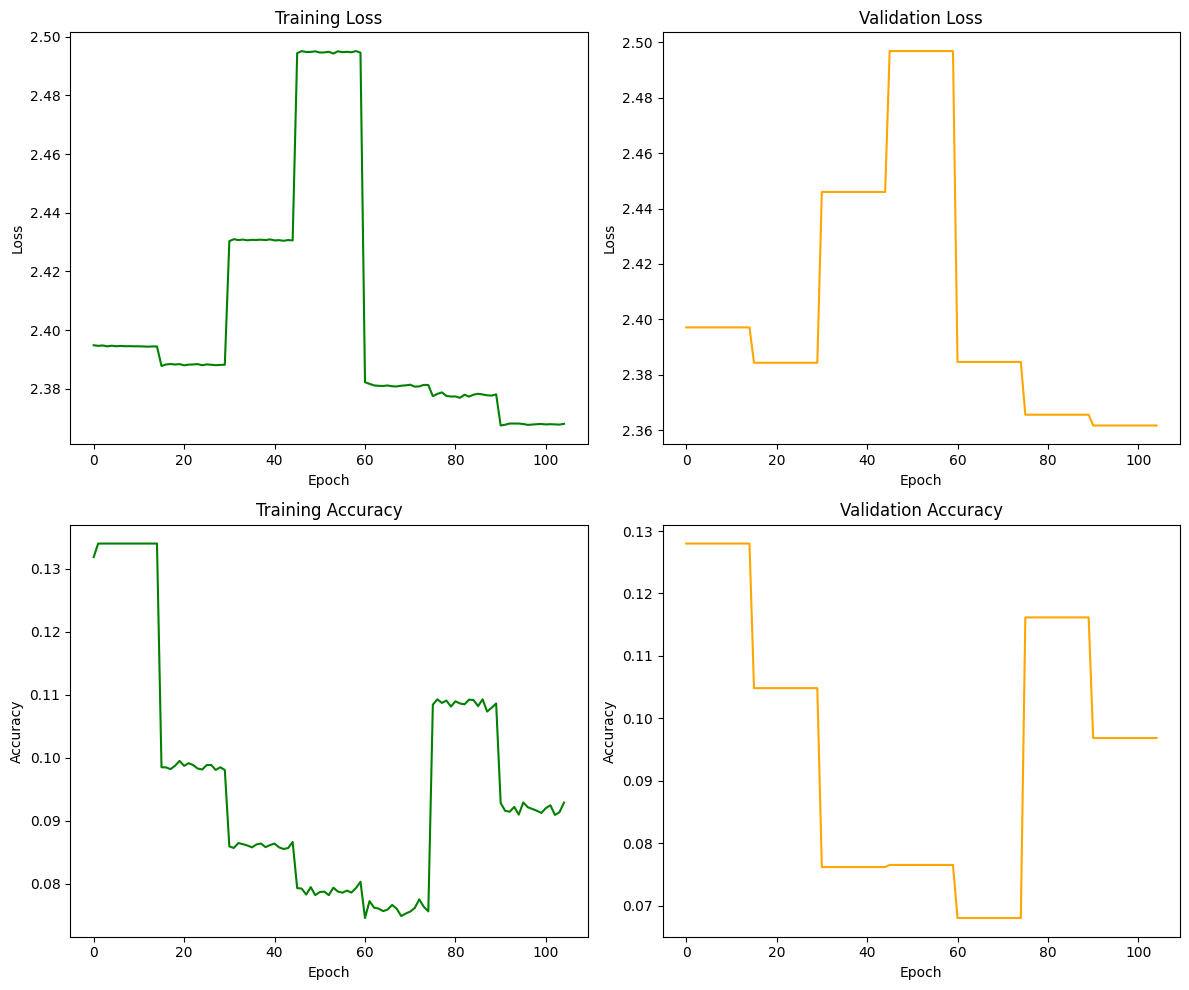

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Validation Loss
ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Training Accuracy
ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Validation Accuracy
ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_target = []
test_predict = []

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        outputs = model(x_test)

        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

print('Evaluation on test set:')
print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.0949


## *2.10. Gradient Normalization*

![image.png](attachment:image.png)

In [ ]:
class GradientNormalization(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input

    @staticmethod
    def backward(ctx, grad_output):
        mean = torch.mean(grad_output)
        std = torch.std(grad_output)
        grad_input = (grad_output - mean) / (std + 1e-6)
        return grad_input


class GradientNormalizationLayer(nn.Module):
    def __init__(self):
        super(GradientNormalizationLayer, self).__init__()

    def forward(self, x):
        return GradientNormalization.apply(x)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
            GradientNormalizationLayer(),
        )
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
            GradientNormalizationLayer(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
            GradientNormalizationLayer(),
        )
        self.hidden_layer2 = nn.Sequential(
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
            GradientNormalizationLayer(),
        )
        self.hidden_layer3 = nn.Sequential(
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
            GradientNormalizationLayer(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
            GradientNormalizationLayer(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
            GradientNormalizationLayer(),
        )
        self.output_layer = nn.Sequential(
            nn.BatchNorm1d(hidden_dims), nn.ReLU(),
            nn.Linear(hidden_dims, output_dims)
        )
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.0, std=0.05)
                nn.init.constant_(layer.bias, val=0.0)

    def forward(self, x):
        x = self.input_layer(x)
        skip = x
        x = self.hidden_layer1(x)
        x = skip + x
        x = self.hidden_layer2(x)
        skip = x
        x = self.hidden_layer3(x)
        x = skip + x
        return self.output_layer(x)

In [ ]:
input_dims = 784
hidden_dims = 128
output_dims = 10
learning_rate = 1e-3

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

summary(model, input_size=(1, 28, 28))  # Input size for FashionMNIST images

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
       BatchNorm1d-3                  [-1, 128]             256
              ReLU-4                  [-1, 128]               0
GradientNormalizationLayer-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
       BatchNorm1d-7                  [-1, 128]             256
              ReLU-8                  [-1, 128]               0
GradientNormalizationLayer-9                  [-1, 128]               0
           Linear-10                  [-1, 128]          16,512
      BatchNorm1d-11                  [-1, 128]             256
             ReLU-12                  [-1, 128]               0
GradientNormalizationLayer-13                  [-1, 128]               0
           Lin

In [ ]:
epochs = 60
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

model.train()
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(input=outputs, dim=1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= count
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= count
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

Epoch 1/60, Train Loss: 0.6550, Train Acc: 0.8020, Validation Loss: 0.4602, Validation Acc: 0.8433
Epoch 2/60, Train Loss: 0.3885, Train Acc: 0.8584, Validation Loss: 0.4010, Validation Acc: 0.8575
Epoch 3/60, Train Loss: 0.3648, Train Acc: 0.8674, Validation Loss: 0.4234, Validation Acc: 0.8510
Epoch 4/60, Train Loss: 0.3529, Train Acc: 0.8711, Validation Loss: 0.4012, Validation Acc: 0.8508
Epoch 5/60, Train Loss: 0.3189, Train Acc: 0.8821, Validation Loss: 0.3483, Validation Acc: 0.8705
Epoch 6/60, Train Loss: 0.3183, Train Acc: 0.8842, Validation Loss: 0.3693, Validation Acc: 0.8703
Epoch 7/60, Train Loss: 0.3515, Train Acc: 0.8752, Validation Loss: 0.4925, Validation Acc: 0.8560
Epoch 8/60, Train Loss: 2.1486, Train Acc: 0.7742, Validation Loss: 4.3283, Validation Acc: 0.6380
Epoch 9/60, Train Loss: 23.9918, Train Acc: 0.4695, Validation Loss: 38.7118, Validation Acc: 0.1987
Epoch 10/60, Train Loss: 807.3941, Train Acc: 0.2150, Validation Loss: 2.6703, Validation Acc: 0.2888
Epoch

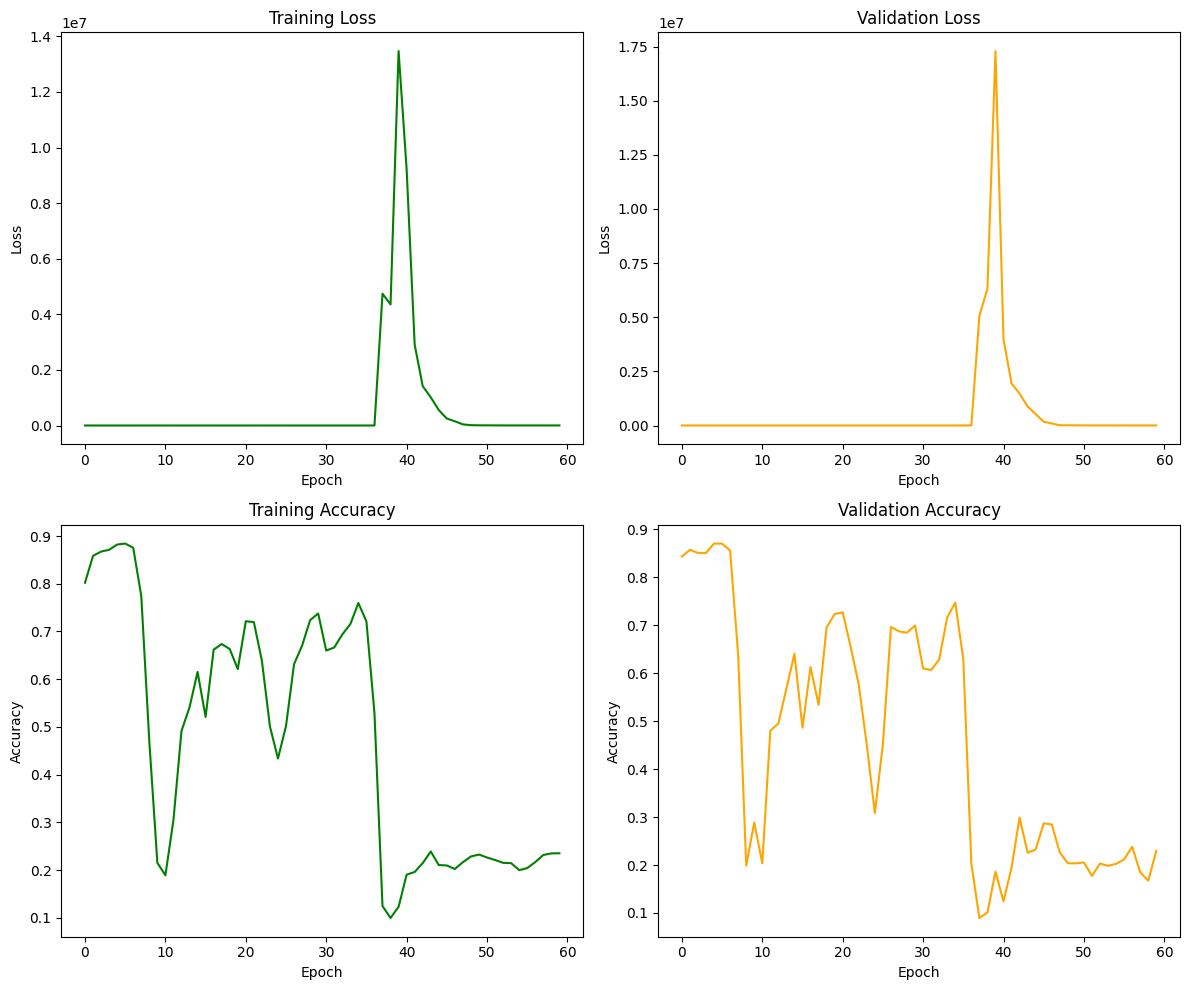

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Validation Loss
ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Training Accuracy
ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Validation Accuracy
ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_target = []
test_predict = []

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        outputs = model(x_test)

        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

print('Evaluation on test set:')
print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.2404
